In [3]:
import gzip
import pickle 
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=15)
import numpy as np
import torch 
import dgl
import pandas as pd
import numpy as np
import plotly.express as px
sys.path.append("/afs/cern.ch/work/m/mgarciam/private/Tracking_wcoc/")
from sklearn.cluster import DBSCAN
from torch_scatter import scatter_max, scatter_add, scatter_mean
# from src.layers.inference_oc import get_clustering, obtain_intersection_values
from scipy.optimize import linear_sum_assignment
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from src.utils.inference.pandas_helpers import open_mlpf_dataframe
list_all_df_hdb = []
path_hgcal = "/eos/user/m/mgarciam/EVAL_REPOS/Tracking_CLD/models/230724/showers_df_evaluation/0_0_0.pt"
sd_hgb, matched_hgb = open_mlpf_dataframe(path_hgcal, False)
path_hgcal = "/eos/user/m/mgarciam/EVAL_REPOS/Tracking_CLD/models/230724/showers_df_evaluation/0_0_1.pt"
sd_hgb_ct, matched_hgb = open_mlpf_dataframe(path_hgcal, False)


In [46]:
# path_hgcal = "/eos/user/m/mgarciam/EVAL_REPOS/Tracking_CLD/models/230724/showers_df_evaluation/3100_4000_1.pt"
# sd_hgb_ct, matched_hgb = open_mlpf_dataframe(path_hgcal, False)

In [5]:

mask_R = sd_hgb_ct["R"].values<0.05
mask_number_unique_hits =  sd_hgb_ct["number_unique_hits"].values>3
mask_theta_lower = sd_hgb_ct["theta"].values>(10/180*np.pi)
mask_theta_higher = sd_hgb_ct["theta"].values<(170/180*np.pi)
mask_delta_MC = sd_hgb_ct["delta_MC"].values>0.02
mask_pt = sd_hgb_ct["true_showers_pt"].values>1
mask_gen_status = sd_hgb_ct["gen_status"]==1
total_mask_ct = mask_R*mask_theta_lower*mask_theta_higher*mask_delta_MC*mask_gen_status*mask_number_unique_hits
mask_delta_plot = mask_R*mask_theta_lower*mask_theta_higher*mask_pt*mask_gen_status*mask_number_unique_hits
mask_no_R = mask_theta_lower*mask_theta_higher*mask_delta_MC*mask_pt*mask_gen_status*mask_number_unique_hits
total_mask_ct_all_partices = mask_R*mask_theta_lower*mask_theta_higher*mask_delta_MC*mask_number_unique_hits
print(len(sd_hgb_ct), len( sd_hgb_ct[total_mask_ct]))
reconstructable_ct = sd_hgb_ct[total_mask_ct]
reco_R_ct  = sd_hgb_ct[mask_no_R]
reco_delta_plot = sd_hgb_ct[mask_delta_plot]
reconstructable_ct_all_p = sd_hgb_ct[total_mask_ct_all_partices]
mask_R = sd_hgb["R"].values<0.05
mask_number_unique_hits =  sd_hgb["number_unique_hits"].values>3
mask_theta_lower = sd_hgb["theta"].values>(10/180*np.pi)
mask_theta_higher = sd_hgb["theta"].values<(170/180*np.pi)
mask_delta_MC = sd_hgb["delta_MC"].values>0.02
mask_pt = sd_hgb["true_showers_pt"].values>1
mask_gen_status = sd_hgb["gen_status"]==1
total_mask = mask_R*mask_theta_lower*mask_theta_higher*mask_delta_MC*mask_gen_status*mask_number_unique_hits
mask_delta_plot = mask_R*mask_theta_lower*mask_theta_higher*mask_pt*mask_gen_status*mask_number_unique_hits
mask_no_R = mask_theta_lower*mask_theta_higher*mask_delta_MC*mask_pt*mask_gen_status*mask_number_unique_hits
total_mask_all_particles = mask_R*mask_theta_lower*mask_theta_higher*mask_delta_MC*mask_number_unique_hits
print(len(sd_hgb), len(sd_hgb[total_mask]))
reconstructable_ml = sd_hgb[total_mask]
reconstructable_ml_all_p = sd_hgb[total_mask_all_particles]
reco_R_ml   = sd_hgb[mask_no_R]
reco_delta_plot_ml = sd_hgb[mask_delta_plot]

295989 171220
298974 171220


In [5]:
reconstructable_ct

,reco_showers_E,true_showers_E,true_showers_pt,pred_showers_E,e_pred_and_truth,vtx_hits,cdc_hits,delta_MC,R,theta,gen_status,number_unique_hits,number_unique_hits_reconstructed
0,12.0,10.705401,10.060724,10.0,9.0,6.0,0.0,0.322313,0.000794,1.221987,1.0,12.0,9.0
1,18.0,7.937959,3.434099,16.0,16.0,6.0,0.0,0.256230,0.000794,0.447394,1.0,15.0,13.0
2,15.0,0.371691,0.332688,5.0,5.0,6.0,0.0,0.768745,0.000794,1.108584,1.0,13.0,5.0
3,17.0,1.300511,0.450378,11.0,11.0,6.0,0.0,0.260252,0.000794,0.353633,1.0,14.0,10.0
4,14.0,0.698237,0.283159,12.0,12.0,4.0,0.0,0.138844,0.000794,0.417564,1.0,13.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,10.0,1.798550,1.003514,3.0,3.0,0.0,0.0,0.240712,0.001079,0.591922,1.0,9.0,3.0
7,11.0,0.566210,0.335728,NaN,NaN,0.0,0.0,0.261584,0.001079,0.634704,1.0,9.0,NaN
8,13.0,0.571285,0.542941,5.0,5.0,6.0,0.0,0.792945,0.001079,1.887121,1.0,12.0,5.0
9,14.0,1.546998,1.041862,12.0,12.0,6.0,0.0,0.270129,0.001079,2.402695,1.0,14.0,12.0


In [56]:
particle_purity = reconstructable_ct["e_pred_and_truth"].values/reconstructable_ct["reco_showers_E"].values
track_purity = reconstructable_ct["e_pred_and_truth"].values/reconstructable_ct["pred_showers_E"].values
good_ct = np.sum((particle_purity>=0.5)*(track_purity>=0.5))/len(reconstructable_ct)
split_ct = np.sum((particle_purity<0.5)*(track_purity>=0.5))/len(reconstructable_ct)
multiple_ct = np.sum((particle_purity>=0.5)*(track_purity<0.5))/len(reconstructable_ct)
bad_ct = np.sum((particle_purity<0.5)*(track_purity<0.5))/len(reconstructable_ct)
nan_ct = np.sum(np.isnan(particle_purity))/len(reconstructable_ct)

particle_purity = reconstructable_ml["e_pred_and_truth"].values/reconstructable_ml["reco_showers_E"].values
track_purity = reconstructable_ml["e_pred_and_truth"].values/reconstructable_ml["pred_showers_E"].values
good_ml = np.sum((particle_purity>=0.5)*(track_purity>=0.5))/len(reconstructable_ml)
split_ml = np.sum((particle_purity<0.5)*(track_purity>=0.5))/len(reconstructable_ml)
multiple_ml = np.sum((particle_purity>=0.5)*(track_purity<0.5))/len(reconstructable_ml)
bad_ml = np.sum((particle_purity<0.5)*(track_purity<0.5))/len(reconstructable_ml)
nan_ml = np.sum(np.isnan(particle_purity))/len(reconstructable_ml)
print(good_ct,split_ct, multiple_ct,bad_ct,nan_ct )
print(good_ml,split_ml, multiple_ml,bad_ml,nan_ml )

good_ml_idea = 0.9803275338323467
split_ml_idea =0.00421367287489219
multiple_ml_idea = 0.0019293183652404028
bad_ml_idea = 4.8492741675701326e-05
nan_ml_idea = 0.013480982185844969

0.750414671183273 0.2203305688587782 2.336175680411167e-05 0.0004672351360822334 0.028764163065062492
0.9659619203364093 0.016861347973367597 0.00479500058404392 0.0010337577385819414 0.011347973367597243


<Figure size 800x800 with 0 Axes>

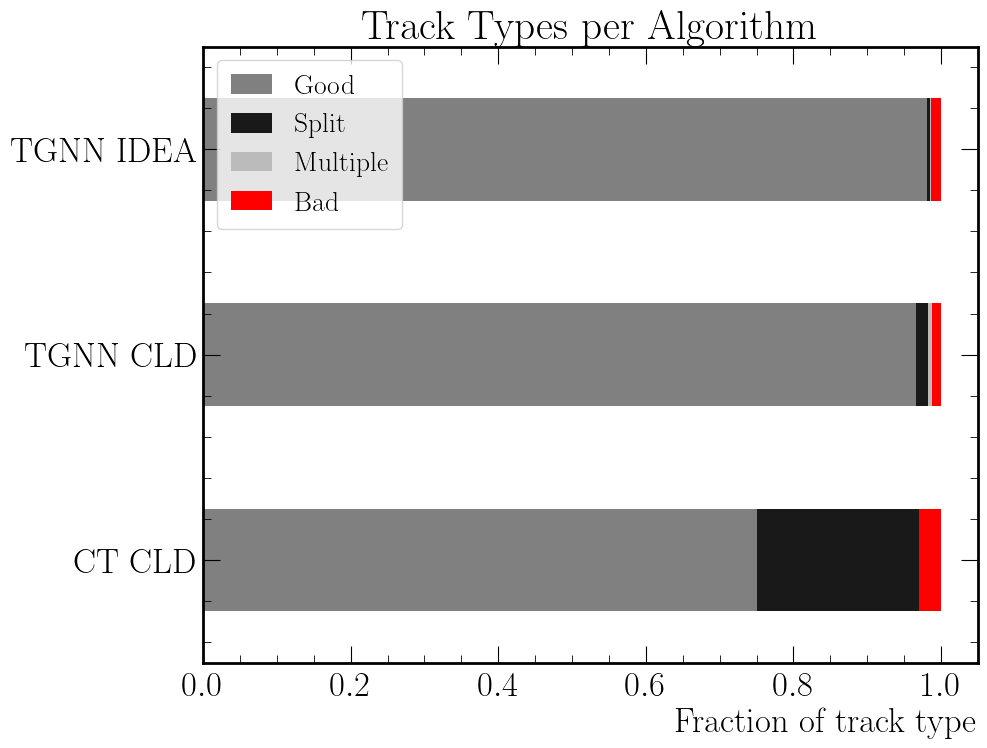

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame structure (you should replace this with your actual data)
data = {
    'Algorithm': ['CT CLD', 'TGNN CLD','TGNN IDEA' ],
    'Good': [good_ct,good_ml,good_ml_idea ],
    'Split': [split_ct, split_ml,split_ml_idea],
    'Multiple': [multiple_ct, multiple_ml, multiple_ml_idea],
    'Bad': [bad_ct+nan_ct, bad_ml+nan_ml, bad_ml_idea+nan_ml_idea]
}

df = pd.DataFrame(data)
my_colors = [ "#810f7c","#8856a7","#8c96c6", "#b3cde3",   "#edf8fb"]
my_colors = ["#808080","#191919", "#bbbbbb", "#ff0000", "#f28686"]
# Set 'Algorithm' as index
df.set_index('Algorithm', inplace=True)

# Plot
fig= plt.figure( figsize=(8, 8))
# ax = fig.add_subplot(111)
ax = df.plot(kind='barh', stacked=True, figsize=(10, 8), color=my_colors)
# Labels and title
ax.set_xlabel('Fraction of track type')
ax.set_ylabel('')
ax.set_title('Track Types per Algorithm')

# Show legend at a specific location
plt.legend(loc='upper left',  framealpha=1, edgecolor='black')
legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.rc("text", usetex=True)
plt.rc("font", family="serif")
plt.rcParams['text.usetex'] = True
size_font = 25
plt.rcParams['font.size'] = size_font
plt.rcParams['axes.labelsize'] = size_font
plt.rcParams['xtick.labelsize'] = size_font
plt.rcParams['ytick.labelsize'] = size_font
plt.rcParams['legend.fontsize'] = 20
plt.show()

In [47]:
more_than_4_hits = sd_hgb["pred_showers_E"]>3
print(np.sum(np.isnan(sd_hgb["reco_showers_E"][more_than_4_hits].values))/np.sum(~np.isnan(sd_hgb["reco_showers_E"][more_than_4_hits].values))*100)
more_than_4_hits = sd_hgb_ct["pred_showers_E"]>3
print(np.sum(np.isnan(sd_hgb_ct["reco_showers_E"][more_than_4_hits].values))/np.sum(~np.isnan(sd_hgb_ct["reco_showers_E"][more_than_4_hits].values))*100)

4.8163200570964095
5.428804237115502


In [48]:
eff_dict_ct = create_eff_dic(reconstructable_ct,reco_R_ct,reco_delta_plot)
# eff_dict_ct_all_p = create_eff_dic(reconstructable_ct_all_p,reco_R_ct,reco_delta_plot)

In [49]:
eff_dict_ml = create_eff_dic(reconstructable_ml,reco_R_ml,reco_delta_plot_ml)
# eff_dict_ml_all_p = create_eff_dic(reconstructable_ml_all_p,reco_R_ml,reco_delta_plot_ml)

(61,) (61,)
(61,) (61,)


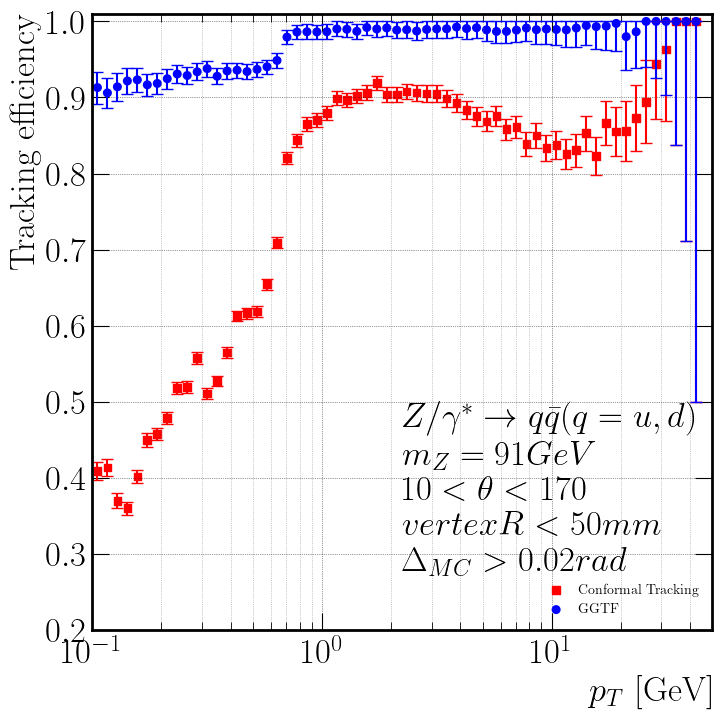

In [51]:
def limit_error_bars(y, yerr, upper_limit=1):
    yerr_upper = np.minimum(y + yerr, upper_limit) - y
    yerr_lower = yerr  # Lower error bars remain unchanged
    return yerr_lower, yerr_upper
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
fig= plt.figure( figsize=(8, 8))
ax = fig.add_subplot(111)
colors_list = ["#FF0000", "#FF0000", "#0000FF"]
index = 0
j = 0
colors = ["r", "b"]
marker = ["s", "o"]
labels = ["Conformal Tracking", "GGTF"]
dataframe_list = [eff_dict_ct, eff_dict_ml]
i =0 
log = True
plt.xlabel("$p_T$ [GeV]")
plt.ylabel("Tracking efficiency")

for i in range(0, len(dataframe_list)):
    print(np.array(dataframe_list[i]["energy_eff"]).shape,  np.array(dataframe_list[i]["eff"]).shape)
    plt.scatter(
        np.array(dataframe_list[i]["energy_eff"]),
        np.array(dataframe_list[i]["eff"]),
        label=labels[i] ,
        marker=marker[i],
        c = [colors[i] for j in range(0,len(dataframe_list[i]["eff"]))],
        s=30,
    )
    error_y = dataframe_list[i]["errors"]
    yerr_lower, yerr_upper = limit_error_bars(np.array(dataframe_list[i]["eff"]), np.array(error_y)/2, upper_limit=1)
    plt.errorbar(dataframe_list[i]["energy_eff"], dataframe_list[i]["eff"] ,yerr= [yerr_lower, yerr_upper], ecolor=colors[i], linestyle='none', capsize=4)

if log:
    log_ = "log"
    plt.xscale("log")
else:
    log_ = ""
# plt.title("CLD")
plt.legend(loc="lower right",title=r'$Z/\gamma^* \rightarrow q \bar q (q=u,d)$' "\n" r"$m_Z=91GeV$" "\n" r"$10< \theta< 170$" "\n" r"$vertex R<50mm$" "\n" r"$\Delta_{MC}>0.02 rad$")

# vertex R<50mm, \Delta_{MC}>0.02 rad
ax.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=4))
ax.xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs='auto', numticks=10))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

plt.minorticks_on()
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.grid(which='major', linestyle=':', linewidth='0.5', color='black')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
# plt.grid(True, which="minor")
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
plt.xlim([1e-1,50])
plt.ylim([0.2,1.01])
plt.rcParams['text.usetex'] = True
size_font = 25
plt.rcParams['font.size'] = size_font
plt.rcParams['axes.labelsize'] = size_font
plt.rcParams['xtick.labelsize'] = size_font
plt.rcParams['ytick.labelsize'] = size_font
plt.rcParams['legend.fontsize'] = 10
leg = ax.get_legend()
leg._legend_box.align = "right"


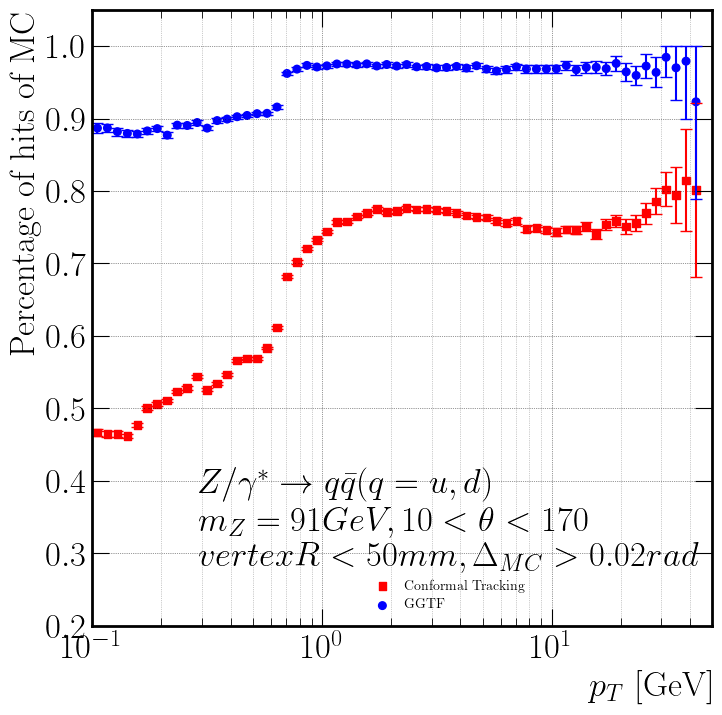

In [52]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
fig= plt.figure( figsize=(8, 8))
ax = fig.add_subplot(111)
colors_list = ["#FF0000", "#FF0000", "#0000FF"]
index = 0
j = 0
colors = ["r", "b"]
marker = ["s", "o"]
labels = ["Conformal Tracking", "GGTF"]
dataframe_list = [eff_dict_ct, eff_dict_ml]
i =0 
log = True
plt.xlabel("$p_T$ [GeV]")
plt.ylabel("Percentage of hits of MC")

for i in range(0, len(dataframe_list)):
    plt.scatter(
        np.array(dataframe_list[i]["energy_eff"]),
        np.array(dataframe_list[i]["number_of_hits"]),
        label=labels[i] ,
        marker=marker[i],
        c = [colors[i] for j in range(0,len(dataframe_list[i]["number_of_hits"]))],
        s=30,
    )
    error_y = dataframe_list[i]["number_of_hits_var"]
    yerr_lower, yerr_upper = limit_error_bars(np.array(dataframe_list[i]["number_of_hits"]), np.array(error_y)/2, upper_limit=1)
    plt.errorbar(dataframe_list[i]["energy_eff"], dataframe_list[i]["number_of_hits"] ,yerr= [yerr_lower, yerr_upper], ecolor=colors[i], linestyle='none', capsize=4)

if log:
    log_ = "log"
    plt.xscale("log")
else:
    log_ = ""
# plt.title("CLD")
plt.legend(loc="lower right",title=r'$Z/\gamma^* \rightarrow q \bar q (q=u,d)$' "\n" r"$m_Z=91GeV, 10<\theta< 170$" "\n" r"$vertex R<50mm, \Delta_{MC}>0.02 rad$")


ax.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=4))
ax.xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs='auto', numticks=10))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.grid(which='major', linestyle=':', linewidth='0.5', color='black')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
# plt.grid(True, which="minor")
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
plt.xlim([1e-1,50])
plt.ylim([0.2,1.05])
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] =size_font
plt.rcParams['axes.labelsize'] = size_font
plt.rcParams['xtick.labelsize'] = size_font
plt.rcParams['ytick.labelsize'] = size_font
plt.rcParams['legend.fontsize'] = 10

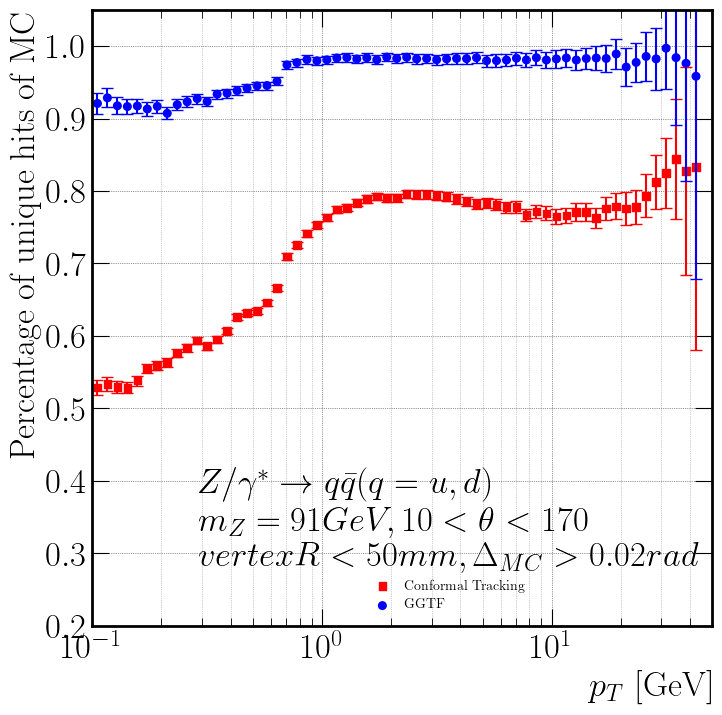

In [198]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
fig= plt.figure( figsize=(8, 8))
ax = fig.add_subplot(111)
colors_list = ["#FF0000", "#FF0000", "#0000FF"]
index = 0
j = 0
colors = ["r", "b"]
marker = ["s", "o"]
labels = ["Conformal Tracking", "GGTF"]
dataframe_list = [eff_dict_ct, eff_dict_ml]
i =0 
log = True
plt.xlabel("$p_T$ [GeV]")
plt.ylabel("Percentage of unique hits of MC")

for i in range(0, len(dataframe_list)):
    plt.scatter(
        np.array(dataframe_list[i]["energy_eff"]),
        np.array(dataframe_list[i]["number_of_hits_unique"]),
        label=labels[i] ,
        marker=marker[i],
        c = [colors[i] for j in range(0,len(dataframe_list[i]["number_of_hits_unique"]))],
        s=30,
    )
    error_y = dataframe_list[i]["number_of_hits_var_unique"]
    yerr_lower, yerr_upper = limit_error_bars(np.array(dataframe_list[i]["number_of_hits_unique"]), np.array(error_y)/2, upper_limit=1)
    plt.errorbar(dataframe_list[i]["energy_eff"], dataframe_list[i]["number_of_hits_unique"] ,yerr= error_y, ecolor=colors[i], linestyle='none', capsize=4)

if log:
    log_ = "log"
    plt.xscale("log")
else:
    log_ = ""
# plt.title("CLD")
plt.legend(loc="lower right",title=r'$Z/\gamma^* \rightarrow q \bar q (q=u,d)$' "\n" r"$m_Z=91GeV, 10<\theta< 170$" "\n" r"$vertex R<50mm, \Delta_{MC}>0.02 rad$")


ax.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=4))
ax.xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs='auto', numticks=10))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.grid(which='major', linestyle=':', linewidth='0.5', color='black')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
# plt.grid(True, which="minor")
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
plt.xlim([1e-1,50])
plt.ylim([0.2,1.05])
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = size_font
plt.rcParams['axes.labelsize'] = size_font
plt.rcParams['xtick.labelsize'] = size_font
plt.rcParams['ytick.labelsize'] = size_font
plt.rcParams['legend.fontsize'] = 10

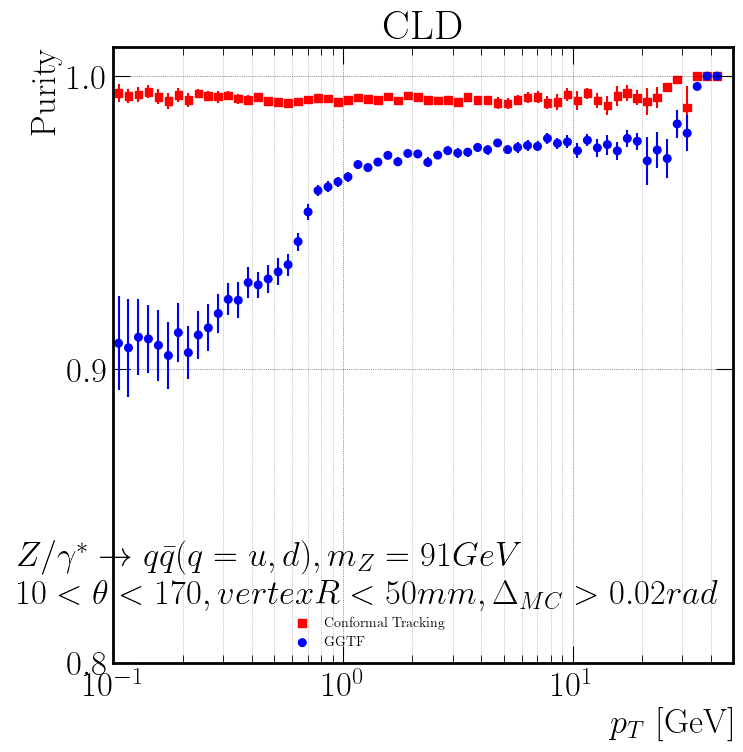

In [195]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
fig= plt.figure( figsize=(8, 8))
ax = fig.add_subplot(111)
colors_list = ["#FF0000", "#FF0000", "#0000FF"]
index = 0
j = 0
colors = ["r", "b"]
marker = ["s", "o"]
labels = ["Conformal Tracking", "GGTF"]
dataframe_list = [eff_dict_ct, eff_dict_ml]
i =0 
log = True
plt.xlabel("$p_T$ [GeV]")
plt.ylabel("Purity")

for i in range(0, len(dataframe_list)):
    plt.scatter(
        np.array(dataframe_list[i]["energy_eff"]),
        np.array(dataframe_list[i]["purity"]),
        label=labels[i] ,
        marker=marker[i],
        c = [colors[i] for j in range(0,len(dataframe_list[i]["purity"]))],
        s=30,
    )
    error_y = dataframe_list[i]["purity_var"]
    yerr_lower, yerr_upper = limit_error_bars(np.array(dataframe_list[i]["purity"]), np.array(error_y), upper_limit=1)
    plt.errorbar(dataframe_list[i]["energy_eff"], dataframe_list[i]["purity"] ,yerr= [yerr_lower, yerr_upper], ecolor=colors[i], linestyle='none')

if log:
    log_ = "log"
    plt.xscale("log")
else:
    log_ = ""
plt.title("CLD")
plt.legend(loc="lower right",title=r'$Z/\gamma^* \rightarrow q \bar q (q=u,d), m_Z=91GeV$' "\n" r"$10< \theta< 170,vertex R<50mm, \Delta_{MC}>0.02 rad$")


ax.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=4))
ax.xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs='auto', numticks=10))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.grid(which='major', linestyle=':', linewidth='0.5', color='black')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
# plt.grid(True, which="minor")
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
plt.xlim([1e-1,50])
plt.ylim([0.8,1.01])
plt.rcParams['text.usetex'] = True
size_font = 25
plt.rcParams['font.size'] = size_font
plt.rcParams['axes.labelsize'] = size_font
plt.rcParams['xtick.labelsize'] = size_font
plt.rcParams['ytick.labelsize'] = size_font
plt.rcParams['legend.fontsize'] = 10

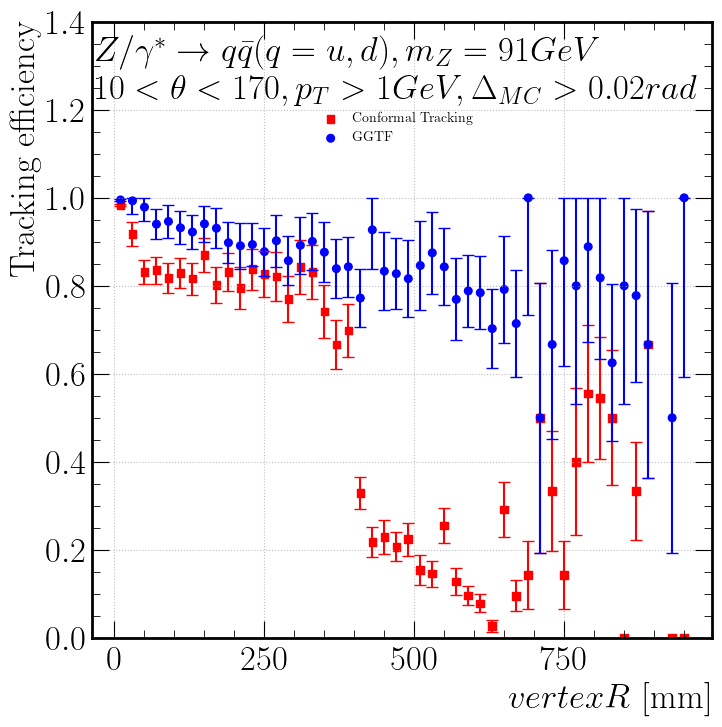

In [203]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
fig= plt.figure( figsize=(8, 8))
ax = fig.add_subplot(111)
colors_list = ["#FF0000", "#FF0000", "#0000FF"]
index = 0
j = 0
colors = ["r", "b"]
marker = ["s", "o"]
labels = ["Conformal Tracking", "GGTF"]
dataframe_list = [eff_dict_ct, eff_dict_ml]
i =0 
log = True
plt.xlabel("$vertexR$ [mm]")
plt.ylabel("Tracking efficiency")

for i in range(0, len(dataframe_list)):
    plt.scatter(
        np.array(dataframe_list[i]["energy_v"]),
        np.array(dataframe_list[i]["eff_v"]),
        label=labels[i] ,
        marker=marker[i],
        c = [colors[i] for j in range(0,len(dataframe_list[i]["eff_v"]))],
        s=30,
    )
    error_y = dataframe_list[i]["errors_v"]
    yerr_lower, yerr_upper = limit_error_bars(np.array(dataframe_list[i]["eff_v"]), np.array(error_y)/2, upper_limit=1)
    plt.errorbar(dataframe_list[i]["energy_v"], dataframe_list[i]["eff_v"] ,yerr= [yerr_lower, yerr_upper], ecolor=colors[i], linestyle='none', capsize=4)


# plt.title("CLD")
plt.legend(loc="upper right",title=r'$Z/\gamma^* \rightarrow q \bar q (q=u,d), m_Z=91GeV$' "\n" r"$10< \theta< 170,p_T>1 GeV, \Delta_{MC}>0.02 rad$")


# ax.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=4))
# ax.xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs='auto', numticks=10))
# ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
# ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
# ax.grid(which='major', linestyle=':', linewidth='0.5', color='black')
# ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.grid(True)
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
# plt.xlim([1e-1,50])
plt.ylim([0,1.4])
size_font  = 25
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = size_font
plt.rcParams['axes.labelsize'] = size_font
plt.rcParams['xtick.labelsize'] = size_font
plt.rcParams['ytick.labelsize'] = size_font
plt.rcParams['legend.fontsize'] = 10

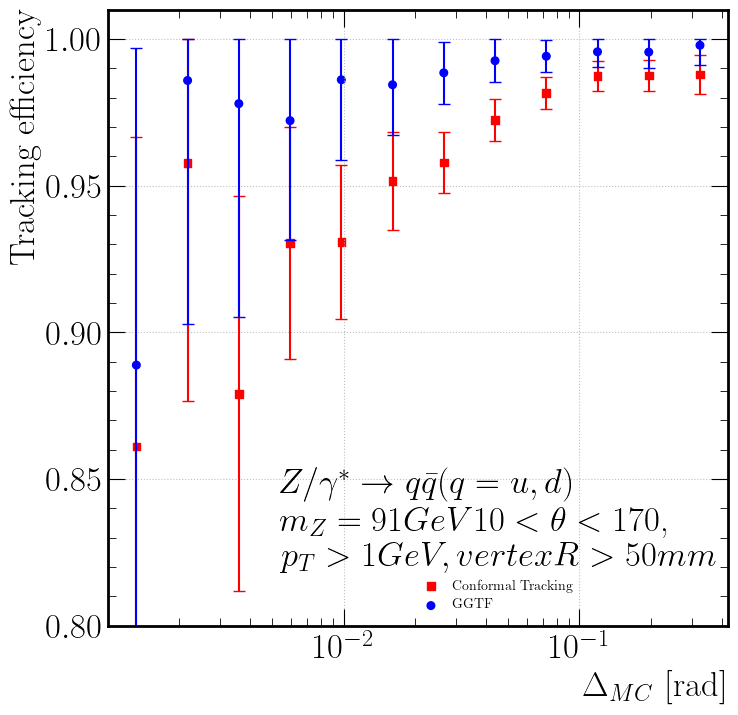

In [204]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
fig= plt.figure( figsize=(8, 8))
ax = fig.add_subplot(111)
colors_list = ["#FF0000", "#FF0000", "#0000FF"]
index = 0
j = 0
colors = ["r", "b"]
marker = ["s", "o"]
labels = ["Conformal Tracking", "GGTF"]
dataframe_list = [eff_dict_ct, eff_dict_ml]
i =0 
log = True
plt.xlabel("$\Delta_{MC}$ [rad]")
plt.ylabel("Tracking efficiency")

for i in range(0, len(dataframe_list)):
    plt.scatter(
        np.array(dataframe_list[i]["delta_MC_values"]),
        np.array(dataframe_list[i]["eff_delta_MC"]),
        label=labels[i] ,
        marker=marker[i],
        c = [colors[i] for j in range(0,len(dataframe_list[i]["eff_delta_MC"]))],
        s=30,
    )
    error_y = dataframe_list[i]["errors_delta_mc"]
    yerr_lower, yerr_upper = limit_error_bars(np.array(dataframe_list[i]["eff_delta_MC"]), np.array(error_y)/2, upper_limit=1)
    plt.errorbar(dataframe_list[i]["delta_MC_values"], dataframe_list[i]["eff_delta_MC"] ,yerr= [yerr_lower, yerr_upper], ecolor=colors[i], linestyle='none', capsize=4)


# plt.title("CLD")
plt.legend(loc="lower right",title=r'$Z/\gamma^* \rightarrow q \bar q (q=u,d)$' "\n" r'$m_Z=91GeV 10< \theta< 170$,' "\n" r"$p_T>1 GeV, vertexR>50 mm$")
plt.xscale("log")
# ax.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=4))
# ax.xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs='auto', numticks=10))
# ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
# ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
# ax.grid(which='major', linestyle=':', linewidth='0.5', color='black')
# ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.grid(True)
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
# plt.xlim([1e-1,50])
plt.ylim([0.8,1.01])

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = size_font
plt.rcParams['axes.labelsize'] = size_font
plt.rcParams['xtick.labelsize'] = size_font
plt.rcParams['ytick.labelsize'] = size_font
plt.rcParams['legend.fontsize'] = 10

In [48]:
len(dataframe_list[1]["errors_delta_mc"]),len(dataframe_list[1]["eff_delta_MC"])

(39, 39)

In [44]:

def create_eff_dic(matched_, reco_r,reco_delta):
    df_id = matched_
    photons_dic = calculate_eff(df_id)
    photons_dic = calculate_eff_vertex(reco_r,photons_dic)
    photons_dic = calculate_eff_DeltaMC(reco_delta,photons_dic)
    return photons_dic


def calculate_eff(sd, log_scale=False):
    # if log_scale:
    bins = np.exp(np.arange(np.log(1e-1), np.log(50), 0.1))
    # else:
    #     bins = np.arange(0, 51, 2)
    #bins = [5e-3,0.1,1.80804241e-01,2.98095799e-01, 4.91476884e-01, 8.10308393e-01, 1.33597268e+00,2.20264658e+00, 3.63155027e+00, 5.98741417e+00, 9.87157710e+00,1.62754791e+01, 2.68337287e+01, 4.42413392e+01]
    bins = np.array(bins)
    eff = []
    eff_50 = []
    eff_75 = []
    energy_eff = []
    size_energy_bin = []
    errors = []
    number_of_hits = []
    number_of_hits_var = []
    total_showers_ = []
    purity = []
    purity_var = []
    number_of_hits_unique = []
    number_of_hits_var_unique = []
    for i in range(len(bins) - 1):
        bin_i = bins[i]
        bin_i1 = bins[i + 1]
        mask_above = sd.true_showers_pt.values <= bin_i1
        mask_below = sd.true_showers_pt.values > bin_i
        # this mask takes all E that have values (does not include fakes then)
        mask = mask_below * mask_above
        number_of_non_reconstructed_showers = np.sum(
            np.isnan(sd.pred_showers_E.values)[mask]
        )
        mask_non_nan = ~np.isnan(sd.e_pred_and_truth.values)
        total_showers = len(sd.pred_showers_E.values[mask])
        if total_showers > 0:
            #total_reconstructed_cld_crit = np.sum(sd["e_pred_and_truth"][mask].values>3)
            particle_purity = sd["e_pred_and_truth"][mask].values/sd["reco_showers_E"][mask].values
            track_purity = sd["e_pred_and_truth"][mask].values/sd["pred_showers_E"][mask].values
            more_than_4_hits = sd["pred_showers_E"][mask].values>3
            #total_reconstructed_cld_crit =  np.sum((purity_calc>=0.75)*more_than_4_hits)
            total_reconstructed_cld_crit =  np.sum((particle_purity>=0.5)*(track_purity>=0.5)*more_than_4_hits)
            # print(total_reconstructed_cld_crit)

            # print(total_reconstructed_cld_crit,total_showers )
            percentage_of_hits_MC = sd["e_pred_and_truth"][mask*mask_non_nan].values/sd["reco_showers_E"][mask*mask_non_nan].values
            percentage_of_hits_MC_unique = sd["number_unique_hits_reconstructed"][mask*mask_non_nan].values/sd["number_unique_hits"][mask*mask_non_nan].values
            purity_list =  sd["e_pred_and_truth"][mask*mask_non_nan].values/sd["pred_showers_E"][mask*mask_non_nan].values
            n_t_purity =  sd["e_pred_and_truth"][mask*mask_non_nan].values
            n_f = sd["pred_showers_E"][mask*mask_non_nan].values-n_t_purity
            sigma_t_purity = np.var(n_t_purity)
            sigma_f_purity = np.var(n_f)
            error_purity = (n_f/(n_t_purity+n_f)**2*sigma_t_purity)**2+(n_t_purity*sigma_f_purity/(n_t_purity+n_f)**2)**2
            N = len(error_purity)
            purity.append(np.mean(purity_list))
            purity_var.append(1/N*(np.sqrt(np.sum(error_purity))))
            number_of_hits.append(np.mean(percentage_of_hits_MC))
            number_of_hits_unique.append(np.mean(percentage_of_hits_MC_unique))

            n_r = sd["e_pred_and_truth"][mask*mask_non_nan].values
            n_t = sd["reco_showers_E"][mask*mask_non_nan].values
            error_percentage_of_hits = (n_r/(n_t**2)*np.sqrt(n_t))**2+(1/n_t*np.sqrt(n_r))**2
            N = len(error_percentage_of_hits)
            number_of_hits_var.append(1/N*np.sqrt(np.sum(error_percentage_of_hits)))

            n_r = sd["number_unique_hits_reconstructed"][mask*mask_non_nan].values
            n_t = sd["number_unique_hits"][mask*mask_non_nan].values
            N = len(error_percentage_of_hits)
            error_percentage_of_hits_unique = (n_r/(n_t**2)*np.sqrt(n_t))**2+(1/n_t*np.sqrt(n_r))**2
            number_of_hits_var_unique.append(1/N*np.sqrt(np.sum(error_percentage_of_hits_unique)))
            total_reconstructed_50 = np.sum(percentage_of_hits_MC>0.50)
            total_reconstructed_75 = np.sum(percentage_of_hits_MC>0.75)
            eff.append(
                (total_reconstructed_cld_crit) / total_showers
            )
            eff_50.append(total_reconstructed_50/total_showers)
            eff_75.append(total_reconstructed_75/total_showers)
            energy_eff.append((bin_i1 + bin_i) / 2)
            size_energy_bin.append((bin_i1-bin_i)/2)
            total_showers_.append(total_showers)
            n_total = total_showers
            n_r = total_reconstructed_cld_crit
            error = (n_r/(n_total**2)*np.sqrt(n_total))**2+(1/n_total*np.sqrt(n_r))**2
            error = np.sqrt(error)
            errors.append(error)
        # print(
        #     "bin",
        #     bin_i1,
        #     bin_i,
        #     (total_showers - number_of_non_reconstructed_showers) / total_showers,
        #     total_showers,
        #     (total_showers - number_of_non_reconstructed_showers),
        #     error
        # )
    photons_dic = {}
    photons_dic["purity"]= purity
    photons_dic["number_of_hits_unique"]= number_of_hits_unique
    photons_dic["purity_var"]=purity_var
    # photons_dic["eff_50"] = eff_50
    # photons_dic["eff_75"] = eff_75
    photons_dic["eff"] = eff
    photons_dic["number_of_hits"]=number_of_hits
    photons_dic["number_of_hits_var"]= number_of_hits_var
    photons_dic["number_of_hits_var_unique"] = number_of_hits_var_unique
    photons_dic["energy_eff"] = energy_eff
    photons_dic["total_showers_"] = total_showers_
    photons_dic["size_energy_bin"] = size_energy_bin
    photons_dic["errors"] = errors
    return photons_dic


In [13]:
np.arccos(0.99)/np.pi*180

8.109614455994183

In [42]:
def calculate_eff_vertex(sd,photons_dic):
    # if log_scale:
   
    # else:
    bins = np.arange(0, 1000, 20)
    bins = np.array(bins)
    eff_v = []
    energy_v = []
    errors_v = []
    for i in range(len(bins) - 1):
        bin_i = bins[i]
        bin_i1 = bins[i + 1]
        mask_above = (sd.R.values*1000) <= bin_i1
        mask_below = (sd.R.values*1000) > bin_i
        mask = mask_below * mask_above

        total_showers = len(sd.pred_showers_E.values[mask])
        if total_showers > 0:
            # purity_calc = sd["e_pred_and_truth"][mask].values/sd["pred_showers_E"][mask].values
            # more_than_4_hits = sd["pred_showers_E"][mask].values>3
            # total_reconstructed_cld_crit =  np.sum((purity_calc>=0.75)*more_than_4_hits)
            # total_reconstructed_cld_crit = np.sum(sd["e_pred_and_truth"][mask].values>3)
            particle_purity = sd["e_pred_and_truth"][mask].values/sd["reco_showers_E"][mask].values
            track_purity = sd["e_pred_and_truth"][mask].values/sd["pred_showers_E"][mask].values
            more_than_4_hits = sd["pred_showers_E"][mask].values>3
            #total_reconstructed_cld_crit =  np.sum((purity_calc>=0.75)*more_than_4_hits)
            total_reconstructed_cld_crit =  np.sum((particle_purity>=0.5)*(track_purity>=0.5)*more_than_4_hits)
            eff_v.append(
                (total_reconstructed_cld_crit) / total_showers
            )
            energy_v.append((bin_i1 + bin_i) / 2)
        
            n_total = total_showers
            n_r = total_reconstructed_cld_crit
            error = (n_r/(n_total**2)*np.sqrt(n_total))**2+(1/n_total*np.sqrt(n_r))**2
            error = np.sqrt(error)
            errors_v.append(error)

    photons_dic["eff_v"]= eff_v
    photons_dic["energy_v"]=energy_v
    photons_dic["errors_v"] =errors_v

    return photons_dic


In [43]:

def calculate_eff_DeltaMC(sd, photons, dictlog_scale=False):
    
    bins = np.arange(0.001, 0.4,0.01)
    bins = np.exp(np.arange(np.log(1e-3), np.log(0.5), 0.5))
    eff = []
    energy_eff = []
    total_showers_ = []
    errors_delta_mc = []
    for i in range(len(bins) - 1):
        bin_i = bins[i]
        bin_i1 = bins[i + 1]
        mask_above = sd.delta_MC.values <= bin_i1
        mask_below = sd.delta_MC.values > bin_i
        mask = mask_below * mask_above
        number_of_non_reconstructed_showers = np.sum(
            np.isnan(sd.pred_showers_E.values)[mask]
        )
        total_showers = len(sd.pred_showers_E.values[mask])
        if total_showers > 0:
            # purity_calc = sd["e_pred_and_truth"][mask].values/sd["pred_showers_E"][mask].values
            # more_than_4_hits = sd["pred_showers_E"][mask].values>3
            # total_reconstructed_cld_crit =  np.sum((purity_calc>=0.75)*more_than_4_hits)
            # total_reconstructed_cld_crit = np.sum(sd["e_pred_and_truth"][mask].values>3)
            particle_purity = sd["e_pred_and_truth"][mask].values/sd["reco_showers_E"][mask].values
            track_purity = sd["e_pred_and_truth"][mask].values/sd["pred_showers_E"][mask].values
            more_than_4_hits = sd["pred_showers_E"][mask].values>3
            total_reconstructed_cld_crit =  np.sum((particle_purity>=0.5)*(track_purity>=0.5)*more_than_4_hits)
            eff.append(
                (total_reconstructed_cld_crit) / total_showers
            )
            energy_eff.append((bin_i1 + bin_i) / 2)
            total_showers_.append(total_showers)
            n_total = total_showers
            n_r = total_reconstructed_cld_crit
            error = (n_r/(n_total**2)*np.sqrt(n_total))**2+(1/n_total*np.sqrt(n_r))**2
            error = np.sqrt(error)
            errors_delta_mc.append(error)
    photons["eff_delta_MC"]= eff
    photons["delta_MC_values"]=energy_eff
    photons["errors_delta_mc"]=errors_delta_mc
    return photons

In [169]:
reconstructable_ct

,reco_showers_E,true_showers_E,true_showers_pt,pred_showers_E,e_pred_and_truth,vtx_hits,cdc_hits,delta_MC,R,theta,gen_status,number_unique_hits,number_unique_hits_reconstructed
0,12.0,10.705401,10.060724,10.0,9.0,6.0,0.0,0.322313,0.000794,1.221987,1.0,12.0,10.0
1,18.0,7.937959,3.434099,16.0,16.0,6.0,0.0,0.256230,0.000794,0.447394,1.0,15.0,13.0
2,15.0,0.371691,0.332688,5.0,5.0,6.0,0.0,0.768745,0.000794,1.108584,1.0,13.0,5.0
3,17.0,1.300511,0.450378,11.0,11.0,6.0,0.0,0.260252,0.000794,0.353633,1.0,14.0,10.0
4,14.0,0.698237,0.283159,12.0,12.0,4.0,0.0,0.138844,0.000794,0.417564,1.0,13.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,10.0,1.798550,1.003514,3.0,3.0,0.0,0.0,0.240712,0.001079,0.591922,1.0,9.0,3.0
7,11.0,0.566210,0.335728,NaN,NaN,0.0,0.0,0.261584,0.001079,0.634704,1.0,9.0,NaN
8,13.0,0.571285,0.542941,5.0,5.0,6.0,0.0,0.792945,0.001079,1.887121,1.0,12.0,5.0
9,14.0,1.546998,1.041862,12.0,12.0,6.0,0.0,0.270129,0.001079,2.402695,1.0,14.0,12.0
